In [ ]:
!pwd # 현재 위치

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteS7XSRP/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteS7XSRP/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [4]:
train_data_len = info.splits['train'].num_examples
test_data_len=info.splits['test'].num_examples

In [7]:
print(train_data_len)

3680


In [8]:
def load_image(datapoint):
  img = tf.image.resize(datapoint['image'], (128,128))
  mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

  img = tf.cast(img, tf.float32) # float로 변환
  img = img/255.0                # normalize
  mask = mask - 1

  return img, mask

In [11]:
train_dataset = dataset['train'].map(load_image)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

0.3996089 0.00047392002


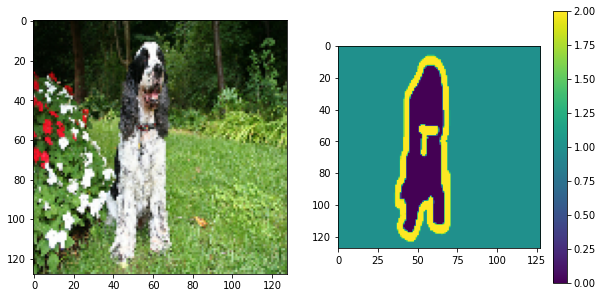

In [16]:
import matplotlib.pyplot as plt

for img, mask in train_dataset.take(1):
  plt.figure(figsize=(10,5))

  plt.subplot(1,2,1)
  plt.imshow(img[1])

  plt.subplot(1,2,2)
  plt.imshow(np.squeeze(mask[1], axis=2))
  plt.colorbar()

  print(np.amax(img[1][2]), np.amin(img[1][2]))

In [20]:
def REDNet_segmentation(num_layers):
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    inputs = tf.keras.layers.Input(shape = (None, None, 3))
    conv_layers.append(tf.keras.layers.Conv2D(3, 
                                              kernel_size = 3, 
                                              padding = 'same', 
                                              activation = 'relu'))

    for i in range(num_layers - 1):
        conv_layers.append(tf.keras.layers.Conv2D(64, 
                                                  kernel_size = 3, 
                                                  padding = 'same', 
                                                  activation = 'relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, 
                                                             kernel_size = 3, 
                                                             padding = 'same', 
                                                             activation = 'relu'))

    deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, 
                                                         kernel_size = 3, 
                                                         padding = 'same', 
                                                         activation = 'softmax'))

    x = conv_layers[0](inputs)

    for i in range(num_layers - 1):
        x = conv_layers[i + 1](x)
        if i % 2 == 0:
            residual_layers.append(x)

    for i in range(num_layers - 1):
        if i % 2 == 1:
            x = tf.keras.layers.Add()([x, residual_layers.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        x = deconv_layers[i](x) 

    x = deconv_layers[-1](x)
    
    model = tf.keras.Model(inputs = inputs, outputs = x)
    return model

In [22]:
model = REDNet_segmentation(15)
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.Adam(0.0001), metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, None, None, 3 84          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 6 1792        conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, None, None, 6 36928       conv2d_16[0][0]                  
____________________________________________________________________________________________

In [ ]:
%%time

history = model.fit(train_dataset, epochs=20, steps_per_epoch=train_data_len //16,
                    validation_data=test_dataset,
                    validation_steps= test_data_len)

Epoch 1/20
230/230 [==============================] - 364s 1s/step - loss: 0.9309 - accuracy: 0.5822 - val_loss: 0.8410 - val_accuracy: 0.5731
Epoch 2/20
230/230 [==============================] - 329s 1s/step - loss: 0.7843 - accuracy: 0.5955 - val_loss: 0.7480 - val_accuracy: 0.6505
Epoch 3/20
230/230 [==============================] - 331s 1s/step - loss: 0.7026 - accuracy: 0.6826 - val_loss: 0.6680 - val_accuracy: 0.7087
Epoch 4/20
230/230 [==============================] - 334s 1s/step - loss: 0.6378 - accuracy: 0.7244 - val_loss: 0.6489 - val_accuracy: 0.7200
Epoch 5/20
230/230 [==============================] - 333s 1s/step - loss: 0.6084 - accuracy: 0.7393 - val_loss: 0.5974 - val_accuracy: 0.7410
Epoch 6/20
230/230 [==============================] - 337s 1s/step - loss: 0.5758 - accuracy: 0.7551 - val_loss: 0.5711 - val_accuracy: 0.7532
Epoch 7/20
230/230 [==============================] - 338s 1s/step - loss: 0.5518 - accuracy: 0.7674 - val_loss: 0.5378 - val_accuracy: 0.7717

In [ ]:
plt.figure(figsize=(12,12))

for idx, (img,mask) in enumerate(test_Dataset.take(3)):
  plt.subplot(3,3, idx*3+1)
  plt.imshow(img[0])

  plt.subplot(3,3, idx*3+2)
  plt.imshow(np.squeeze(mask[0], axis=2))

  predict=tf.argmax(model.predict(img), axis=-1)
  plt.subplot(3,3, idx*3 +3)
  plt.imshow(np.squeesze(predict, axis=0))

In [ ]:
plt.figure(figsize=(12,12))

for idx, datapoint in enumerate(dataset['test'].take(3)):
  img = datapoint['image']
  mask = datapoint['segmentation_mask']

  img = tf.cast(img, tf.float32)
  img = img /255.0
  mask = mask -1

  plt.subplot(3,3, idx*3 +1)
  plit.imshow(img)

  plt.subplot(3,3, idx*3 +2)
  plit.imshow(np.squeeze(mask, axis=2))

  predict = tf.argmax(model.predict(tf.expand_dims(img, axis=0)), axis=-1)
  plt.subplot(3,3, idx*3 +3)
  plt.imshow(np.squeeze(predict, axis=0))
